### IMPORTING LIBRARIES AND MODULES

In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import tqdm

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from torchmetrics.functional import accuracy

import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Bidirectional

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

# Random Stuff That May Not Be Used
from pylab import rcParams
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from multiprocessing import cpu_count

In [127]:
train_path = "D:/ISHAN/NITK STUFF/SEM 6/DL/PROJECT/EEG/train/"
valid_path = "D:/ISHAN/NITK STUFF/SEM 6/DL/PROJECT/EEG/valid/"
train_labels = "D:/ISHAN/NITK STUFF/SEM 6/DL/PROJECT/EEG/train_labels.csv"
valid_labels = "D:/ISHAN/NITK STUFF/SEM 6/DL/PROJECT/EEG/valid_labels.csv"

## MERGING DATA FILES

### ONLY REQUIRED ONCE - ALREADY DONE

In [12]:
train_files = [file for file in os.listdir(train_path) if file.endswith('.csv')]
dfs = []
for idx, file in enumerate(train_files):
    file_path = os.path.join(train_path, file)
    df = pd.read_csv(file_path)
    df = df.groupby(np.arange(len(df)) // 3).mean()                         # Reduce number of rows in each csv from 4500 to 1500 by averaging 3 rows at a time
    df['id'] = idx
    df = df.drop(columns=['Time'], axis=1)
    df['Time'] = np.arange(0.01, 15.01, 0.01)[:len(df)]                     # Redo the Time column to make it standard for every file
    df = df[['id', 'Time'] + [col for col in df.columns if col not in ['id', 'Time']]]
    dfs.append(df)
merged_df = pd.concat(dfs, ignore_index=True)
merged_df.to_csv('D:/ISHAN/NITK STUFF/SEM 6/DL/PROJECT/EEG/train_merged.csv', index=False)

In [13]:
valid_files = [file for file in os.listdir(valid_path) if file.endswith('.csv')]
dfs = []
for idx, file in enumerate(valid_files):
    file_path = os.path.join(valid_path, file)
    df = pd.read_csv(file_path)
    df = df.groupby(np.arange(len(df)) // 3).mean()                         # Reduce number of rows in each csv from 4500 to 1500 by averaging 3 rows at a time
    df['id'] = idx + 360                                                    # Start after training files (360)
    df = df.drop(columns=['Time'], axis=1)
    df['Time'] = np.arange(0.01, 15.01, 0.01)[:len(df)]                     # Redo the Time column to make it standard for every file
    df = df[['id', 'Time'] + [col for col in df.columns if col not in ['id', 'Time']]]
    dfs.append(df)
merged_df = pd.concat(dfs, ignore_index=True)
merged_df.to_csv('D:/ISHAN/NITK STUFF/SEM 6/DL/PROJECT/EEG/valid_merged.csv', index=False)

# PREPROCESSING

In [128]:
train_data = pd.read_csv("train_merged.csv")
valid_data = pd.read_csv("valid_merged.csv")
train_labels = pd.read_csv("train_labels.csv")
valid_labels = pd.read_csv("valid_labels.csv")

In [129]:
cols = train_data.columns
cols

Index(['id', 'Time', 'P3', 'C3', 'F3', 'Fz', 'F4', 'C4', 'P4', 'Cz', 'CM',
       'A1', 'Fp1', 'Fp2', 'T3', 'T5', 'O1', 'O2', 'X3', 'X2', 'F7', 'F8',
       'X1', 'A2', 'T6', 'T4'],
      dtype='object')

In [130]:
# If scaling is required
'''
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data)
valid_data = scaler.transform(valid_data)
'''

'\nscaler = StandardScaler()\ntrain_data = scaler.fit_transform(train_data)\nvalid_data = scaler.transform(valid_data)\n'

In [131]:
class_label_mapping = {
    'fear': 0,
    'joy': 1,
    'disgust': 2,
    'sadness': 3,
    'surprise': 4,
    'anger': 5
}

emotion_classes = ['fear', 'joy', 'disgust', 'sadness', 'surprise', 'anger']

reverse_label_mapping = {
    0 : 'fear',
    1 : 'joy',
    2 : 'disgust',
    3 : 'sadness',
    4 : 'surprise',
    5 : 'anger'
}

In [132]:
X_train = train_data.iloc[:, 2:].copy()
X_valid = valid_data.iloc[:, 2:].copy()
X_train = X_train.values.reshape((360, 1500, 24)) 
X_valid = X_valid.values.reshape((180, 1500, 24))
X_train.shape, X_valid.shape

((360, 1500, 24), (180, 1500, 24))

In [133]:
y_train = train_labels.copy()
y_valid = valid_labels.copy()
y_train['label'] = y_train['class'].map(class_label_mapping)
y_valid['label'] = y_valid['class'].map(class_label_mapping)

y_train = np.eye(6)[y_train['label'].values]
y_valid = np.eye(6)[y_valid['label'].values]

y_train.shape, y_valid.shape

((360, 6), (180, 6))

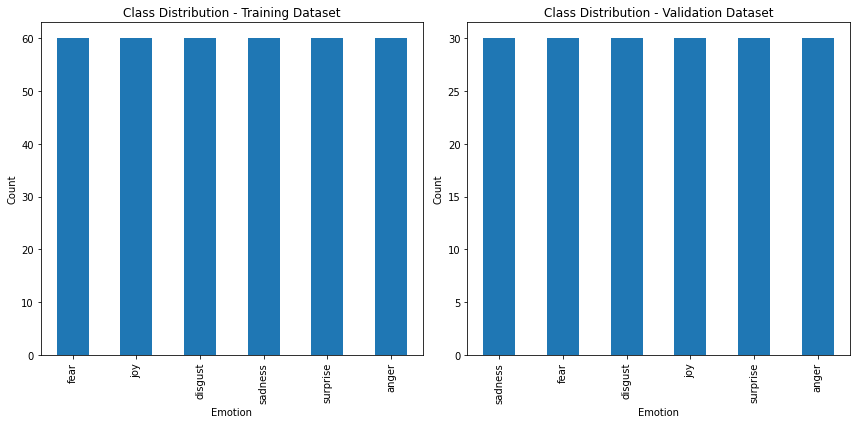

In [134]:
# Class Distributions

plt.figure(figsize=(12, 6))

# Training dataset
plt.subplot(1, 2, 1)
train_labels['class'].value_counts().plot(kind='bar')
plt.title('Class Distribution - Training Dataset')
plt.xlabel('Emotion')
plt.ylabel('Count')

# Validation dataset
plt.subplot(1, 2, 2)
valid_labels['class'].value_counts().plot(kind='bar')
plt.title('Class Distribution - Validation Dataset')
plt.xlabel('Emotion')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

## LSTM

In [116]:
model = keras.Sequential([
    keras.layers.LSTM(units=128, return_sequences=True, input_shape=(1500, 24)),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(units=64, return_sequences=True),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(units=32),
    keras.layers.Dense(units=6, activation='softmax')
])

In [117]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 1500, 128)         78336     
                                                                 
 dropout_4 (Dropout)         (None, 1500, 128)         0         
                                                                 
 lstm_13 (LSTM)              (None, 1500, 64)          49408     
                                                                 
 dropout_5 (Dropout)         (None, 1500, 64)          0         
                                                                 
 lstm_14 (LSTM)              (None, 32)                12416     
                                                                 
 dense_6 (Dense)             (None, 6)                 198       
                                                                 
Total params: 140,358
Trainable params: 140,358
Non-tr

In [118]:
optimizer = Adam(lr = 0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

c:\Users\ishan\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [119]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_filepath = 'best_model.h5'
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, 
                                      monitor='val_accuracy', 
                                      save_best_only=True,
                                      mode='max', 
                                      verbose=1)

In [120]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, 
                    validation_data=(X_valid, y_valid), 
                    callbacks=[checkpoint_callback])

Epoch 1/20
12/12 [==============================] - ETA: 0s - loss: 1.8993 - accuracy: 0.1000
Epoch 1: val_accuracy improved from -inf to 0.17778, saving model to best_model.h5
12/12 [==============================] - 49s 4s/step - loss: 1.8993 - accuracy: 0.1000 - val_loss: 1.8088 - val_accuracy: 0.1778
Epoch 2/20
12/12 [==============================] - ETA: 0s - loss: 1.8059 - accuracy: 0.1694
Epoch 2: val_accuracy improved from 0.17778 to 0.19444, saving model to best_model.h5
12/12 [==============================] - 39s 3s/step - loss: 1.8059 - accuracy: 0.1694 - val_loss: 1.8077 - val_accuracy: 0.1944
Epoch 3/20
12/12 [==============================] - ETA: 0s - loss: 1.7630 - accuracy: 0.1944
Epoch 3: val_accuracy did not improve from 0.19444
12/12 [==============================] - 39s 3s/step - loss: 1.7630 - accuracy: 0.1944 - val_loss: 1.8245 - val_accuracy: 0.1611
Epoch 4/20
12/12 [==============================] - ETA: 0s - loss: 1.7235 - accuracy: 0.2722
Epoch 4: val_accu

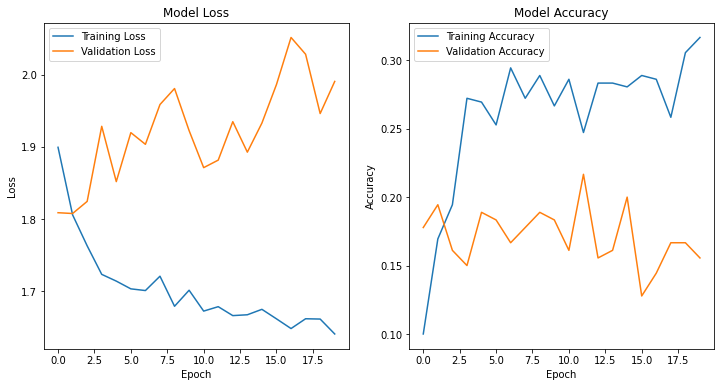

In [121]:
plt.figure(figsize=(12, 6))

# training & validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [122]:
best_model = keras.models.load_model(checkpoint_filepath)

In [123]:
y_pred_probs = best_model.predict(X_valid)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_valid, axis=1)

6/6 [==============================] - 7s 884ms/step


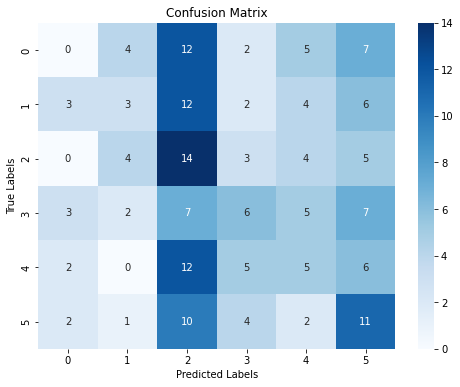

In [124]:
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [125]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.21      0.10      0.14        30
           2       0.21      0.47      0.29        30
           3       0.27      0.20      0.23        30
           4       0.20      0.17      0.18        30
           5       0.26      0.37      0.31        30

    accuracy                           0.22       180
   macro avg       0.19      0.22      0.19       180
weighted avg       0.19      0.22      0.19       180



## RNN

In [135]:
model = keras.Sequential([
    keras.layers.SimpleRNN(units=128, return_sequences=True, input_shape=(1500, 24)),
    keras.layers.Dropout(0.2),
    keras.layers.SimpleRNN(units=64, return_sequences=True),
    keras.layers.Dropout(0.2),
    keras.layers.SimpleRNN(units=32),
    keras.layers.Dense(units=6, activation='softmax')
])

In [136]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 1500, 128)         19584     
                                                                 
 dropout_6 (Dropout)         (None, 1500, 128)         0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 1500, 64)          12352     
                                                                 
 dropout_7 (Dropout)         (None, 1500, 64)          0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dense_7 (Dense)             (None, 6)                 198       
                                                                 
Total params: 35,238
Trainable params: 35,238
Non-trai

In [137]:
optimizer = Adam(lr = 0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

c:\Users\ishan\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [138]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_filepath = 'best_model.h5'
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, 
                                      monitor='val_accuracy', 
                                      save_best_only=True,
                                      mode='max', 
                                      verbose=1)

In [139]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, 
                    validation_data=(X_valid, y_valid), 
                    callbacks=[checkpoint_callback])

Epoch 1/20
12/12 [==============================] - ETA: 0s - loss: 2.1087 - accuracy: 0.1278
Epoch 1: val_accuracy improved from -inf to 0.14444, saving model to best_model.h5
12/12 [==============================] - 20s 1s/step - loss: 2.1087 - accuracy: 0.1278 - val_loss: 1.9796 - val_accuracy: 0.1444
Epoch 2/20
12/12 [==============================] - ETA: 0s - loss: 1.9072 - accuracy: 0.1750
Epoch 2: val_accuracy improved from 0.14444 to 0.16667, saving model to best_model.h5
12/12 [==============================] - 16s 1s/step - loss: 1.9072 - accuracy: 0.1750 - val_loss: 1.8819 - val_accuracy: 0.1667
Epoch 3/20
12/12 [==============================] - ETA: 0s - loss: 1.8222 - accuracy: 0.2000
Epoch 3: val_accuracy improved from 0.16667 to 0.17222, saving model to best_model.h5
12/12 [==============================] - 16s 1s/step - loss: 1.8222 - accuracy: 0.2000 - val_loss: 1.8829 - val_accuracy: 0.1722
Epoch 4/20
12/12 [==============================] - ETA: 0s - loss: 1.7717 -

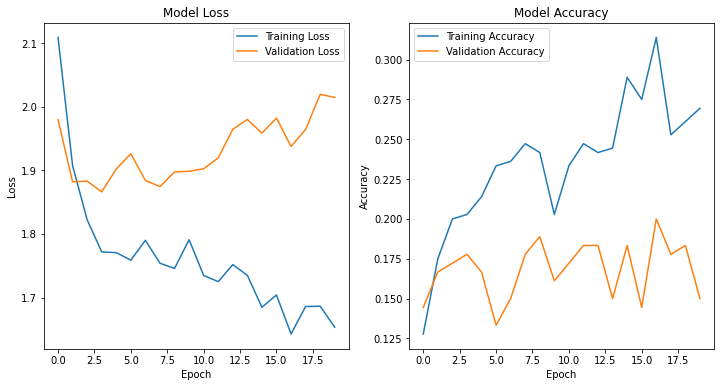

In [140]:
plt.figure(figsize=(12, 6))

# training & validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [141]:
best_model = keras.models.load_model(checkpoint_filepath)

In [142]:
y_pred_probs = best_model.predict(X_valid)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_valid, axis=1)

6/6 [==============================] - 2s 262ms/step


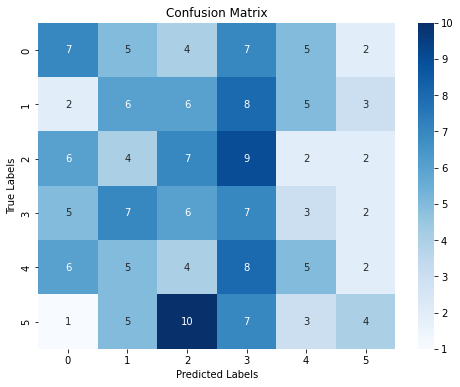

In [143]:
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [144]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.26      0.23      0.25        30
           1       0.19      0.20      0.19        30
           2       0.19      0.23      0.21        30
           3       0.15      0.23      0.18        30
           4       0.22      0.17      0.19        30
           5       0.27      0.13      0.18        30

    accuracy                           0.20       180
   macro avg       0.21      0.20      0.20       180
weighted avg       0.21      0.20      0.20       180



## BiRNN

In [145]:
model = keras.Sequential([
    keras.layers.Bidirectional(keras.layers.SimpleRNN(units=128, return_sequences=True), input_shape=(1500, 24)),
    keras.layers.Dropout(0.2),
    keras.layers.Bidirectional(keras.layers.SimpleRNN(units=64, return_sequences=True)),
    keras.layers.Dropout(0.2),
    keras.layers.Bidirectional(keras.layers.SimpleRNN(units=32)),
    keras.layers.Dense(units=6, activation='softmax')
])

In [146]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 1500, 256)        39168     
 l)                                                              
                                                                 
 dropout_8 (Dropout)         (None, 1500, 256)         0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 1500, 128)        41088     
 nal)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 1500, 128)         0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               10304     
 nal)                                                            
                                                      

In [147]:
optimizer = Adam(lr = 0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

c:\Users\ishan\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [148]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_filepath = 'best_model.h5'
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, 
                                      monitor='val_accuracy', 
                                      save_best_only=True,
                                      mode='max', 
                                      verbose=1)

In [149]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, 
                    validation_data=(X_valid, y_valid), 
                    callbacks=[checkpoint_callback])

Epoch 1/20
12/12 [==============================] - ETA: 0s - loss: 2.1600 - accuracy: 0.1500
Epoch 1: val_accuracy improved from -inf to 0.15000, saving model to best_model.h5
12/12 [==============================] - 37s 3s/step - loss: 2.1600 - accuracy: 0.1500 - val_loss: 2.0544 - val_accuracy: 0.1500
Epoch 2/20
12/12 [==============================] - ETA: 0s - loss: 1.8847 - accuracy: 0.2333
Epoch 2: val_accuracy improved from 0.15000 to 0.16111, saving model to best_model.h5
12/12 [==============================] - 32s 3s/step - loss: 1.8847 - accuracy: 0.2333 - val_loss: 2.0261 - val_accuracy: 0.1611
Epoch 3/20
12/12 [==============================] - ETA: 0s - loss: 1.7447 - accuracy: 0.2444
Epoch 3: val_accuracy did not improve from 0.16111
12/12 [==============================] - 30s 3s/step - loss: 1.7447 - accuracy: 0.2444 - val_loss: 2.0111 - val_accuracy: 0.1333
Epoch 4/20
12/12 [==============================] - ETA: 0s - loss: 1.7589 - accuracy: 0.2333
Epoch 4: val_accu

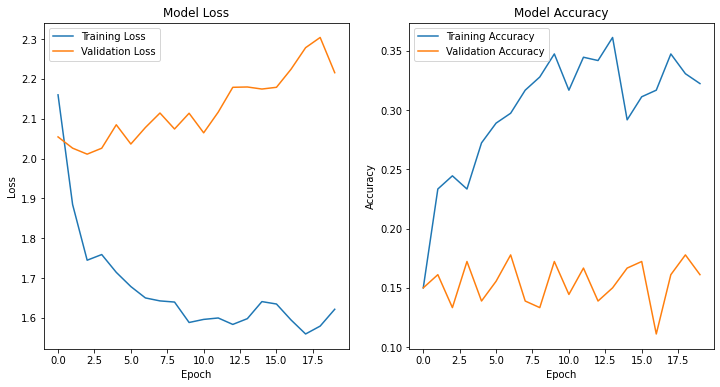

In [150]:
plt.figure(figsize=(12, 6))

# training & validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [151]:
best_model = keras.models.load_model(checkpoint_filepath)

In [152]:
y_pred_probs = best_model.predict(X_valid)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_valid, axis=1)

6/6 [==============================] - 9s 783ms/step


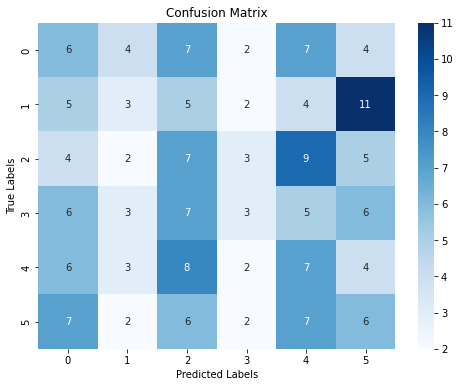

In [153]:
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [154]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.18      0.20      0.19        30
           1       0.18      0.10      0.13        30
           2       0.17      0.23      0.20        30
           3       0.21      0.10      0.14        30
           4       0.18      0.23      0.20        30
           5       0.17      0.20      0.18        30

    accuracy                           0.18       180
   macro avg       0.18      0.18      0.17       180
weighted avg       0.18      0.18      0.17       180



## BiLSTM

In [155]:
model = keras.Sequential([
    keras.layers.Bidirectional(keras.layers.LSTM(units=128, return_sequences=True), input_shape=(1500, 24)),
    keras.layers.Dropout(0.2),
    keras.layers.Bidirectional(keras.layers.LSTM(units=64, return_sequences=True)),
    keras.layers.Dropout(0.2),
    keras.layers.Bidirectional(keras.layers.LSTM(units=32)),
    keras.layers.Dense(units=6, activation='softmax')
])

In [156]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirectio  (None, 1500, 256)        156672    
 nal)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 1500, 256)         0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 1500, 128)        164352    
 nal)                                                            
                                                                 
 dropout_11 (Dropout)        (None, 1500, 128)         0         
                                                                 
 bidirectional_5 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                      

In [157]:
optimizer = Adam(lr = 0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

c:\Users\ishan\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [158]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_filepath = 'best_model.h5'
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, 
                                      monitor='val_accuracy', 
                                      save_best_only=True,
                                      mode='max', 
                                      verbose=1)

In [159]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, 
                    validation_data=(X_valid, y_valid), 
                    callbacks=[checkpoint_callback])

Epoch 1/20
12/12 [==============================] - ETA: 0s - loss: 1.9379 - accuracy: 0.1500
Epoch 1: val_accuracy improved from -inf to 0.15556, saving model to best_model.h5
12/12 [==============================] - 118s 9s/step - loss: 1.9379 - accuracy: 0.1500 - val_loss: 1.8350 - val_accuracy: 0.1556
Epoch 2/20
12/12 [==============================] - ETA: 0s - loss: 1.7942 - accuracy: 0.1972
Epoch 2: val_accuracy improved from 0.15556 to 0.16111, saving model to best_model.h5
12/12 [==============================] - 95s 8s/step - loss: 1.7942 - accuracy: 0.1972 - val_loss: 1.8140 - val_accuracy: 0.1611
Epoch 3/20
12/12 [==============================] - ETA: 0s - loss: 1.7231 - accuracy: 0.2806
Epoch 3: val_accuracy did not improve from 0.16111
12/12 [==============================] - 93s 8s/step - loss: 1.7231 - accuracy: 0.2806 - val_loss: 1.8866 - val_accuracy: 0.1500
Epoch 4/20
12/12 [==============================] - ETA: 0s - loss: 1.6675 - accuracy: 0.2583
Epoch 4: val_acc

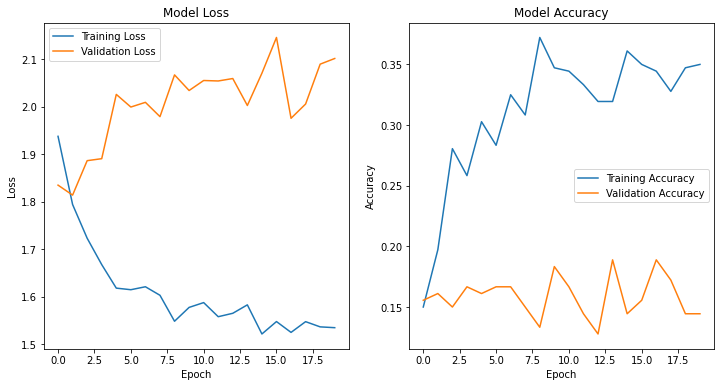

In [160]:
plt.figure(figsize=(12, 6))

# training & validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [161]:
best_model = keras.models.load_model(checkpoint_filepath)

In [162]:
y_pred_probs = best_model.predict(X_valid)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_valid, axis=1)

6/6 [==============================] - 16s 2s/step


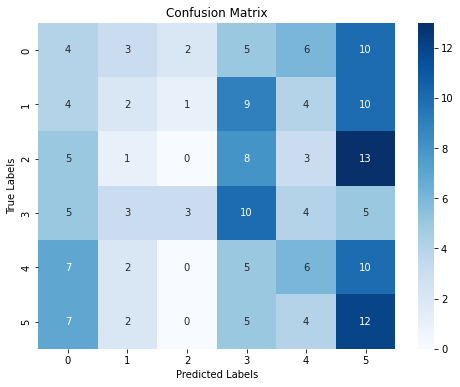

In [163]:
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [164]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.12      0.13      0.13        30
           1       0.15      0.07      0.09        30
           2       0.00      0.00      0.00        30
           3       0.24      0.33      0.28        30
           4       0.22      0.20      0.21        30
           5       0.20      0.40      0.27        30

    accuracy                           0.19       180
   macro avg       0.16      0.19      0.16       180
weighted avg       0.16      0.19      0.16       180

